# Clean vs Tidy Room Detector

Notebook ini menjelaskan implementasi detektor kebersihan ruangan menggunakan tensorflow.

## Requirements

Untuk menjalankan notebook ini, diperlukan dependensi berikut:
1. Python 3.11.9
2. Tensorflow 2.16.1
3. Numpy 1.26.4
4. Matplotlib 3.9.0
5. Sckit-Learn 1.5.0

In [1]:
import os

import tensorflow as tf
import numpy as np
import sklearn
import matplotlib as mt
import matplotlib.pyplot as plt

from tensorflow.keras import losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

2024-07-09 21:31:55.125212: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 21:31:55.157843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 21:31:55.738138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)
print(np.version.full_version)
print(mt.__version__)
print(sklearn.__version__)

2.16.1
1.26.4
3.9.0
1.5.0


## Dataset

Dataset yang digunakan adalah [Dataset Messy Clean Room](https://dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com/184/messy-vs-clean-room.zip) dari Dicoding.

## Data Preparation

Bagian ini menjelaskan terkait dengan persiapan data. Pada bagian ini, dataset akan dilakukan pelabelan dan augmentasi gambar.

In [3]:
TRAINING_DIR = "data/images/train"
os.listdir(TRAINING_DIR)

['clean', 'messy']

In [4]:
VALIDATION_DIR = "data/images/val"
os.listdir(VALIDATION_DIR)

['clean', 'messy']

In [5]:
train_generator = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  horizontal_flip=True,
  shear_range = 0.2,
  fill_mode = 'nearest',
).flow_from_directory(
  TRAINING_DIR,
  target_size=(150, 150),
  batch_size=4,
  class_mode='binary'
)

Found 192 images belonging to 2 classes.


In [6]:
validation_generator = ImageDataGenerator(
  rescale=1./255,
).flow_from_directory(
  TRAINING_DIR,
  target_size=(150, 150),
  batch_size=4,
  class_mode='binary'
)

Found 192 images belonging to 2 classes.


## Model

Bagian ini menjelaskan terkait dengan model yang akan digunakan untuk memprediksi kelas `clean` dan `tidy`.

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/home/miawheker/.pyenv/versions/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-09 21:31:56.984881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 21:31:57.018031: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu fo

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Berikut merupakan proses _learning_ yang dilakukan.

In [9]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [10]:
model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator
)

Epoch 1/50


/home/miawheker/.pyenv/versions/tensorflow/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/miawheker/.pyenv/versions/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6115 - loss: 0.8116 - val_accuracy: 0.7031 - val_loss: 0.5341
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.6425 - loss: 0.6481 - val_accuracy: 0.5990 - val_loss: 0.6152
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7064 - loss: 0.5821 - val_accuracy: 0.8073 - val_loss: 0.4672
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7704 - loss: 0.5339 - val_accuracy: 0.7708 - val_loss: 0.4771
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7706 - loss: 0.5102 - val_accuracy: 0.6979 - val_loss: 0.5341
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7712 - loss: 0.5599 - val_accuracy: 0.7292 - val_loss: 0.4938
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7643 - loss: 0.5389 - val_accuracy: 0.6354 - val_loss: 0.6068
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7968 - loss: 0.4167 - val_accuracy: 0.8073 - val_

## Evalutation

Pada bagian ini, akan dicoba untuk melakukan evaluasi model.

In [11]:
TEST_DIR_CLEAN = "data/images/test/clean"
os.listdir(TEST_DIR_CLEAN)

['0.png', '1.png', '3.png', '6.png', '9.png']

In [12]:
TEST_DIR_MESSY = "data/images/test/messy"
os.listdir(TEST_DIR_MESSY)

['2.png', '4.png', '5.png', '7.png', '8.png']

In [13]:
image_x = []
image_y = []

for i in os.listdir(TEST_DIR_CLEAN):
    img = image.load_img(TEST_DIR_CLEAN + "/" + i, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    image_x.append(np.vstack([x]))
    image_y.append(0.0)

for i in os.listdir(TEST_DIR_MESSY):
    img = image.load_img(TEST_DIR_MESSY + "/" + i, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    image_x.append(np.vstack([x]))
    image_y.append(1.0)

In [14]:
predict_y = []

for i in image_x:
    predict_y.append(round(model.predict(i)[0,0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [15]:
accuracy_score(image_y, predict_y)

0.8

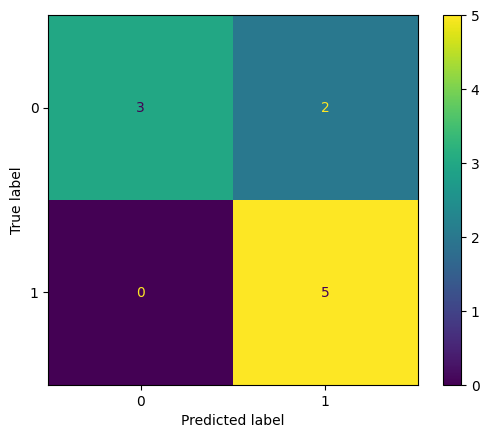

In [16]:
res = confusion_matrix(image_y, predict_y)
display = ConfusionMatrixDisplay(confusion_matrix=res)

display.plot()